# Генерацию данных с акселерометра

## Поставленная задача:

- Всю траекторию можно задать какими-нибудь контрольными точками-отрезками. 
- На каждом отрезке машина пусть двигается со скоростью 60км/ч. 
- Ускорение пусть будет равномерное до скорости 60 и до 0. 
- Пусть машина разгоняется до 60 км/ч за 3 секунды. 
- GPS координата пусть приходит каждую секунду 
- Акселерометр пусть выдает данные 1000 раз в секунду.
- Вот у тебя точка А и Б. Берёшь азимут от А к Б . 
- И на него откладываешь вектор ускорения. 
- А потом просто этот вектор разбиваешь на 2:
    - один направляешь на север, 
    - второй - перпендикулярно ему.


## Создаём точки

In [1]:
from math import cos, sin, sqrt
from typing import List, Tuple
from random import randint
import matplotlib.pyplot as plt

In [ ]:
class Accelerometer():
    def __init__(self):
        self.amount_points: int = 15                            # кол-во точек
        self.t_GPS: float = 1.0                                 # сек
        self.t_accel: float = 0.01                              # сек
        self.speed_const: float = 60                            # км/ч
        self.t_max_spid: float = 3                              # сек
        self.accel: float = self.speed_const/self.t_max_spid    # км/(ч^2) 
        self.c: int = int(self.speed_const/self.t_accel)

Построение точки будет происходить простейшим образом.
Начиная с нулевой координаты будем прибавлять каждый раз рандомно от 30 до 1000 метров, рандомно по x и y.

In [2]:
# генерируем точки
def point_generate(self) -> Tuple[List[float], List[float]]: 
        
    x: List[float] = [0.0]
    y: List[float] = [0.0]
    lens_x: float = 0.0
    lens_y: float = 0.0
        
    for i in range(0, self.amount_points):
        lens_x += randint(45,1000)
        lens_y += randint(45,1000)
        x.append(lens_x)
        y.append(lens_y)
    return x, y 

## Задаём параметры скорости и ускорения, находим точки каждый момент времени.

Нам известно что координаты должны приходить каждую секунду.
Но нам в будущем нужно будет записывать данные с акселерометра 1000 раз в секунду.
Поэтому будем брать 1000 долю секунды.

**Для начала найдём общую длину отрезка по координатам:**

$$
L=\sqrt{(x_{2}-x_{1})^2+(y_{2}+y_{1})^2}
$$


In [3]:
# вычисляем длину отрезка
def segment_length(self, x: List[float], y: List[float]) -> List[float]: 
    len_L: List[float] = []
    for i in range(1, len(x)):
        L = sqrt((x[i]-x[i-1])**2 + (y[i]+y[i-1])**2)
        len_L.append(L)
    return len_L

**Продемонстрирую как будет изменяться скорость на прямой:**

![title](https://gitlab.com/loony.close.13/test_kalman_filter/-/raw/master/Simul_Sensor/1.jpg)

На рисунке видно то что:
$$L = l_{1}+l_{2}+l_{3}$$
также мы видим что:
$$l_{1}=l_{3}$$
тогда 
$$ L = 2l_{1}+l_{2}$$


**Для того чтобы найти точку нам нужно найти длину пройденного пути:**

$$
\left\{\begin{matrix}
l_{1_{n}} = \sum_{i=0}^{n}(V_{n}t_{n}+\frac{a_{p}t_{n}^{2}}{2})\\ 
l_{2_{n}} = \sum_{i=0}^{n}(V_{p}t_{n})
\end{matrix}\right.
$$

где Vp = 60 - постоянная скорость, 
    ap - ускорение постоянное.
    
так как показания датчика нам нужны 1000 раз в сек то и точек за это 3 секунды ускорения нам нужно 3000, поэтому вычисляем каждую из них.

In [4]:
# длина пройденного пути
def distance(self, len_L: float)-> List[float]:
    speed: List[float] = [0.0]
    l_accel: List[float] = [0.0]
    l_speed: List[float] = [0.0]
    for n in range(0, self.c):
        speed_point = speed[n] + self.accel*self.t_accel
        speed.append(speed_point)
        if speed_point >= self.speed_const:     
            break
        l_accel.append(speed[n]*self.t_accel+(self.accel*self.t_accel**2)/2)

    l_speed_const= len_L-sum(l_accel)*2
    i = l_speed_const/self.speed_const/self.t_accel
    for n in range(0, int(i)):
        l_speed.append(self.speed_const*self.t_accel)  
        
        
    l_all: List[float] = []
    for i in range(1, len(l_accel)):
        l_accel[i] = l_accel[i]+l_accel[i-1]
    l_all.extend(l_accel)

    l_speed[0] = l_speed[0] + l_all[-1]
    for i in range(1, len(l_speed)):
        l_speed[i] = l_speed[i] + l_speed[i-1]
    l_all.extend(l_speed)

    l3: List[float] = l_accel[::-1]
    l3[0] = l3[0] + l_speed[-1]
    for i in range(1, len(l3)):
        l3[i] = l3[i]+l3[i-1]
    l_all.extend(l3)
        
    return l_all

**Затем можно использовать систему уравнений по нахождению координат:**

$$
\left\{\begin{matrix}
x_{n}=\frac{x_{0}+ x_{1}(\sum_{i=0}^{n}\lambda)}{1+\lambda} \\ 
y_{n}=\frac{y_{0}+y_{1}(\sum_{i=0}^{n}\lambda)}{1+\lambda}
\end{matrix}\right.
$$


In [5]:
# координаты точек
def point_coord(self, x0: float, x1: float, y0: float, y1: float, lambda_add: List[float]) -> Tuple[List[float], List[float]]:
    x_n: List[float] = [0.0]
    y_n: List[float] = [0.0]
    for n in range(0, len(lambda_add)):
        x_n.append((x0 + x1 *(lambda_add[n]))/(1+lambda_add[n]))
        y_n.append((y0 + y1 *(lambda_add[n]))/(1+lambda_add[n]))
    return x_n, y_n

 Где lambda отношение пройденной длины ко всей длине:
 
$$
\lambda_{n} = \frac{L}{l_{n}} 
$$


In [6]:
# находим лямбду
def lambda_list(self, L: float, l_all: List[float]) -> List[float]:
    lambda_all: List[float] = []
    for n in range(1, len(l_all)): lambda_all.append(L/l_all[n])
    #for i in range(1, len(lambda_all)): lambda_all[i] = lambda_all[i] + lambda_all[i-1]
    return lambda_all

Рассмотрен случай длины в момент ускорения также он справедлив для момента торможения.


по данному заданию известно что расстояние за первые 3 секунды пройденный путь будет 15 метров, столько же на торможение, необходимое минимальное расстояние 30 метров, также известно что пройденный путь при постоянной скоростью 60 км/ч будет равняться:

$$ l2 = L - 2  l1 = L - 30$$


## Вычисляем вектор скорости и ускорения.

Вектор скорости каждой точки лежит на отрезке перемещения как и ускорение.
Вектор ускорения является вектором изменения скорости во времени.
можно вычислять каждую итерацию отнимать от рассматриваемой точки предыдущую.

$$ a_{n} = V_{n}-V_{n-1} $$

таким образом найти ускорение каждой точке относительно прямой.


## Разбиение вектора на x и y

разбиение будем производить относительно x (который коллинеарен с севером) и у (перпендикулярен к северу):

$$
\left\{\begin{matrix}
a_{x_{n}} = a_{n}cos(\alpha)\\ 
a_{y_{n}} = a_{n}sin(\alpha)
\end{matrix}\right.
$$

А находить угол alpha будем при помощи отношения арктангенса:
$$ \alpha = \frac{\delta_{x}}{\delta_{y}}$$

где delta проекция длины отрезка относительно х и у:
$$
\left\{\begin{matrix}
\delta_{x} = x_{n}-x_{n-1}\\ 
\delta_{y} = y_{n}-y_{n-1}
\end{matrix}\right.
$$

In [7]:
# ускорение 
def point_accel(self, x: List[float], y:List[float]) -> Tuple[List[float], List[float]]:
    accel_x: List[float] = [0.0]
    accel_y: List[float] = [0.0]
    for n in range(1, len(x)):
        accel_x.append(self.accel*cos(x[n]-x[n-1]))
        accel_y.append(self.accel*sin(y[n]-y[n-1]))
    return accel_x, accel_y

In [15]:
def activate(self) -> Tuple[List[float], List[float]]:
    xy = self.point_generate()       
    x = xy[0]
    y = xy[1]
    
    len_L = self.segment_length(x, y)
    accel_xy: Tuple[List[float],List[float]] = ([],[])
    lambda_all = []
    for L in len_L:
        l_all = self.distance(L) 
        lambda_all.append(self.lambda_list(L, l_all))
        
    xy_n: Tuple[List[float],List[float]] = ([],[])
    x_n: List[float] = []
    y_n: List[float] = []

    for i in range(0, len(x)-1):
        xy_n = self.point_coord(x[i], x[i+1], y[i], y[i+1], lambda_all[i])
        x_n.extend(xy_n[0])
        y_n.extend(xy_n[1])
    accel_xy = self.point_accel(x_n, y_n)
    return accel_xy

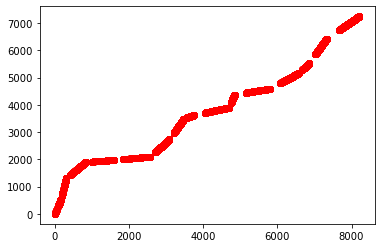

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



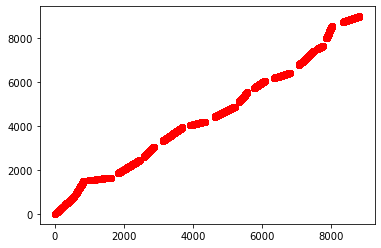

In [1]:
import Accelerometer as Acc
import matplotlib.pyplot as plt

A = Acc.Accelerometer()
xy_accel = A.activate()

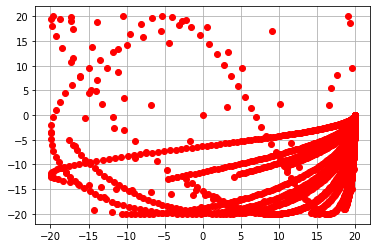

In [2]:
plt.plot(xy_accel[0], xy_accel[1], 'ro')
plt.grid()
plt.show()

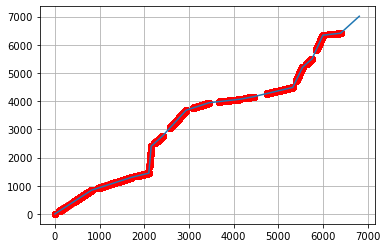

In [5]:
from typing import List, Tuple

xy = A.point_generate()       
x = xy[0]
y = xy[1]

len_L = A.segment_length(x, y)
accel_xy: Tuple[List[float],List[float]] = ([],[])
lambda_all: List[float] = []
for L in len_L:
    l_all = A.distance(L)   
    lambda_all.append(A.lambda_list(L, l_all))

xy_n: Tuple[List[float],List[float]] = ([],[])
x_n: List[float] = []
y_n: List[float] = []

for i in range(0, len(lambda_all)-1):
    xy_n = A.point_coord(x[i], x[i+1], y[i], y[i+1], lambda_all[i])
    x_n.extend(xy_n[0])
    y_n.extend(xy_n[1])
            
    

plt.plot(x_n, y_n, 'ro')
plt.plot(x, y)
plt.grid()
plt.show()

In [9]:
x_GPS = []
y_GPS = []
for n in range(0, len(xy_n[0]), 1000):
    x_GPS.extend(xy_n[0][i])
    y_GPS.extend(xy_n[1][i])

print(x_GPS)

TypeError: 'float' object is not iterable

In [4]:
#Шумы
  
rand_x: List[float] = []
rand_y: List[float] = []
for i in range(0,len(x_GPS)):
    rand_x.append(x_GPS[i] + randint(-100,100)) # это и есть наша дисперсия относительно идеального значения D
    rand_y.append(y_GPS[i] + randint(-100,100))

plt.plot(rand_x, rand_y, 'ro')
plt.plot(x, y)
plt.grid()
plt.show()    

TypeError: 'list' object is not callable